In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import chardet
import ast
import re
from gensim.parsing.preprocessing import remove_stopwords

import collections 
import itertools
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Activation, Dense,Dropout
from scipy.sparse import csr_matrix


In [ ]:
reviews_train =  pd.read_csv(r"./drive/MyDrive/datasets/Computation-Intelligence/project2/train.csv")
reviews_test =  pd.read_csv(r"./drive/MyDrive/datasets/Computation-Intelligence/project2/test.csv")

In [ ]:
np.set_printoptions(suppress=True)

# **PART 0 -- PREPROCESSING**

In [ ]:

reviews_train = reviews_train.drop('Unnamed: 3', 1)
reviews_test = reviews_test.drop('Unnamed: 3', 1)
reviews_test = reviews_test.drop('Unnamed: 4', 1)

reviews = reviews_train.append(reviews_test) #appending both the datasets at 
reviews = reviews.reset_index(drop=True) 

'''removing rows with na values'''
reviews = reviews.dropna() #843 978 1755 1961 have values for "Unnamed: 3" 

'''removing rows with no text for overview'''
reviews = reviews[reviews['overview'].str.contains('[A-Za-z]')]

In [ ]:
reviews.shape

(2990, 3)

In [ ]:
reviews.tail()

,id,genres,overview
2995,2996,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",Military men Rock Reilly and Eddie Devane are ...
2996,2997,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",Three girls in 1980s Stockholm decide to form ...
2997,2998,"[{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...","Samantha Caine, suburban homemaker, is the ide..."
2998,2999,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",Reuben Feffer is a guy who's spent his entire ...
2999,3000,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",A young man sets out to uncover the truth abou...


In [ ]:
'''MODIFYING GENRES FOR REVIEWS'''

for index, row in reviews.iterrows():
  genres = ast.literal_eval(row['genres'])
  st = '' 
  for genre in genres:
    st += f"{genre['name']},"
  st = st[0:-1] 
  reviews.loc[index,'genres'] = st


In [ ]:
reviews.head()

,id,genres,overview
0,1,Comedy,"When Lou, who has become the ""father of the In..."
1,2,"Comedy,Drama,Family,Romance",Mia Thermopolis is now a college graduate and ...
2,3,Drama,"Under the direction of a ruthless instructor, ..."
3,4,"Thriller,Drama",Vidya Bagchi (Vidya Balan) arrives in Kolkata ...
4,5,"Action,Thriller",Marine Boy is the story of a former national s...


**Finding movie by genre popularity in dataset**

In [ ]:
genre_count = collections.Counter(itertools.chain.from_iterable(v.split(',') for v in reviews.genres))

genre_count_df = pd.DataFrame({'Genre': list(genre_count.keys()), 
                              'Count': list(genre_count.values())})

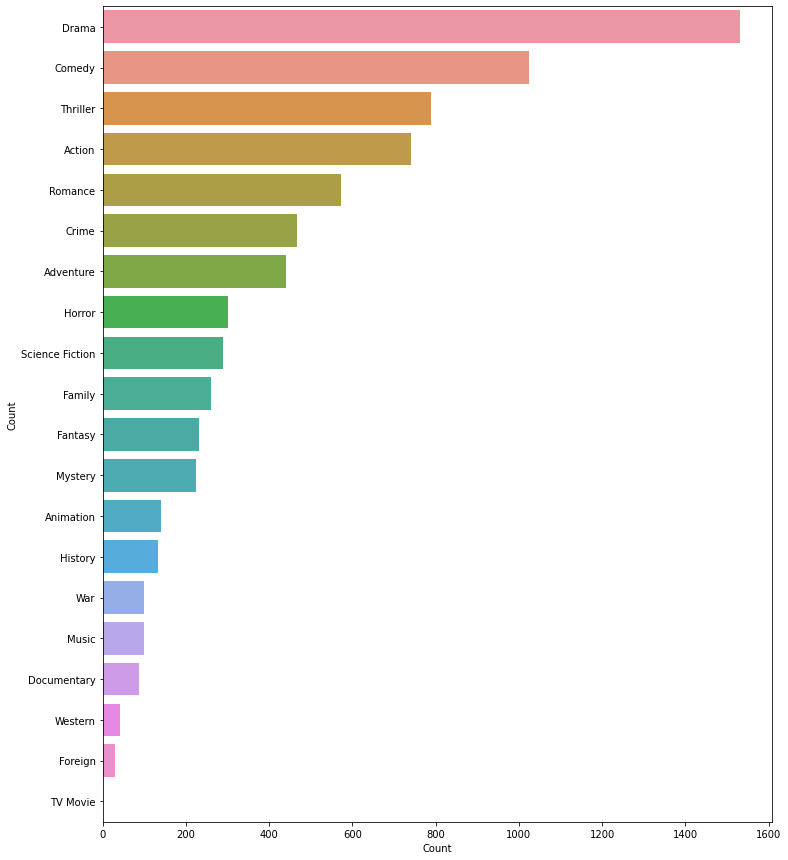

In [ ]:
g = genre_count_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [ ]:
y_dummy = reviews['genres'].str.get_dummies(sep=',')

y_dummy.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
y = y_dummy.values

In [ ]:
y.shape

(2990, 20)

in this section, we will clean up the overview part of the input of our problem

In [ ]:
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text



def final_clean(text):
      return gensim.utils.simple_preprocess (text)


In [ ]:
X = reviews['overview']

X = X.apply(lambda x: clean_text(x))

X = X.apply(remove_stopwords)


#X_w2v = X.apply(lambda x: final_clean(x))

In [ ]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(reviews['genres'].str.split(',')) #THIS WILL BE USED FOR INVERSE TRANSFORM

#multilabel_binarizer.inverse_transform(y)[3]

MultiLabelBinarizer(classes=None, sparse_output=False)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=9) #taking back around 1000 for test set

In [ ]:
xtest.shape

(987,)

In [ ]:
print("**** Y TRAIN HEAD ****\n")
print(*multilabel_binarizer.inverse_transform(ytrain)[0:20],sep='\n')
print("\n")
print(f"{(ytrain)[0:20]}\n\n\n\n\n")

print("**** Y TEST HEAD ****")
print(*multilabel_binarizer.inverse_transform(ytest)[0:20],sep='\n')
print("\n")
print((ytest)[0:20])

**** Y TRAIN HEAD ****

('Action', 'Thriller')
('Action', 'Adventure', 'Fantasy')
('Drama', 'Romance', 'Thriller')
('Comedy', 'Romance')
('Action',)
('Action', 'Crime', 'Drama')
('Animation', 'Comedy', 'Family')
('Animation', 'Drama', 'Science Fiction')
('Crime', 'Drama', 'Mystery')
('Action', 'Crime', 'Thriller')
('Comedy', 'Drama')
('Comedy',)
('Action', 'Comedy', 'Crime', 'Thriller')
('Action', 'Comedy', 'Crime')
('Action', 'Adventure', 'Horror')
('Mystery', 'Thriller')
('Action', 'Adventure', 'Science Fiction', 'Thriller')
('Crime', 'Drama', 'Thriller')
('Drama',)
('Comedy', 'Music')


[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 

# **PART1 -- WORD2VEC**

In [ ]:
SIZE = 150
WINDOW = 3

In [ ]:
#note that since Word2Vec is considered an 'unsupervised' algorithm, so at 
#least during its training, it is not typical to hold back any 'test' data for
#later evaluation.
x_w2v = X.apply(lambda x: final_clean(x))
w2v_model = gensim.models.Word2Vec (x_w2v, size=SIZE, window=WINDOW, min_count=2, workers=10)
w2v_model.train(x_w2v,total_examples=len(x_w2v),epochs=55)




(4083650, 4605645)

In [ ]:
w1 = "love"
w2v_model.wv.most_similar (positive=w1)

[('torettos', 0.7451444268226624),
 ('leaf', 0.7378904223442078),
 ('founder', 0.7053175568580627),
 ('templar', 0.702527642250061),
 ('tree', 0.6809731721878052),
 ('exaggerated', 0.6691275835037231),
 ('dorinda', 0.6527177691459656),
 ('polly', 0.6369556188583374),
 ('taciturn', 0.6227474808692932),
 ('choose', 0.6216972470283508)]

below, we find the feature values for each document by summing over the word features then dividing by the number of words

In [ ]:
x_vec_w2v = np.zeros((len(x_w2v), SIZE))

for idx, paragraph in enumerate(x_w2v): 
  ln = len(paragraph)
  arr = np.zeros(SIZE)
  for word in paragraph:
    try:
      arr = w2v_model[word] + arr
  
    except KeyError:
      ln -= 1
  arr = arr/ln 
  x_vec_w2v[idx,:] = arr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
x_vec_w2v

array([[ 0.05800364, -0.03140321, -0.1998809 , ...,  0.05470591,
         0.08343219,  0.49418802],
       [ 0.00314349,  0.01668595, -0.10400377, ...,  0.04114581,
         0.20812127, -0.00412883],
       [-0.05068643,  0.16530979,  0.00374808, ..., -0.16075336,
         0.23582668,  0.28445294],
       ...,
       [-0.01495533, -0.04183563, -0.18226051, ...,  0.04692973,
         0.00974094,  0.32590705],
       [ 0.02568868,  0.32337885,  0.09206083, ..., -0.02308177,
         0.09237949,  0.15971299],
       [ 0.11649279,  0.48245843, -0.17487718, ..., -0.27471262,
         0.11777654,  0.09803389]])

In [ ]:
xtrain_w2v, xtest_w2v, ytrain_w2v, ytest_w2v = train_test_split(x_vec_w2v, y, test_size=0.33, random_state=9) #now do splitting for classification
                                #note that since parameters same as split above, the y's will be the same as before (ytrain_w2v == ytrain)

**LOGISTIC REGRESSION WITH 1VSALL**

In [ ]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(xtrain_w2v, ytrain_w2v)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [ ]:
y_pred_prob_trn = clf.predict_proba(xtrain_w2v)
y_pred_prob_tst = clf.predict_proba(xtest_w2v)

t = 0.25752 # threshold value
y_pred_lr_trn = (y_pred_prob_trn >= t).astype(int)
y_pred_lr_tst = (y_pred_prob_tst >= t).astype(int)


In [ ]:
nm = 3
print(f"Real value: {multilabel_binarizer.inverse_transform(ytest_w2v)[nm]}")
print(f"predicted value: {multilabel_binarizer.inverse_transform(y_pred_lr_tst)[nm]}")

Real value: ('Action', 'Drama', 'Thriller')
predicted value: ('Action', 'Adventure', 'Drama', 'Thriller')


In [ ]:
print("*** LOGISTIC REGRESSION CLASSIFIER RESULTS ***")
print(f"train set f-score: {f1_score(ytrain, y_pred_lr_trn, average='micro')}")
print(f"test set f-score: {f1_score(ytest, y_pred_lr_tst, average='micro')}")


*** LOGISTIC REGRESSION CLASSIFIER RESULTS ***
train set f-score: 0.5685043433387804
test set f-score: 0.5430136018371312


**NEURAL NETWORK**

In [ ]:
NUM_HIDDEN_LAYERS = 1
LAYER_SIZE = 145

In [ ]:
def get_model(n_inputs, n_outputs):
  model = Sequential()
  model.add(Dropout(0.2,input_dim=n_inputs))
  model.add(Dense(LAYER_SIZE, kernel_initializer='he_uniform', activation='tanh'))
  for _ in range (NUM_HIDDEN_LAYERS-1):
    model.add(Dense(int(LAYER_SIZE), kernel_initializer='he_uniform', activation='tanh'))
  model.add(Dense(n_outputs, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics='accuracy')
  return model
 

x_train, y_train = xtrain_w2v, ytrain_w2v
n_inputs, n_outputs = x_train.shape[1], y_train.shape[1]

model = get_model(n_inputs, n_outputs)
history = model.fit(x_train, y_train, verbose=0, epochs=200, validation_split=0.1)


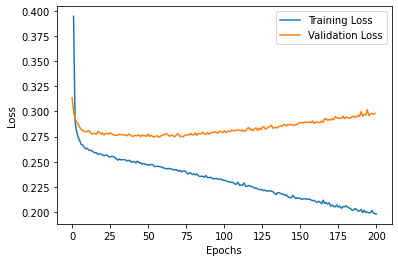

In [ ]:
loss_values = history.history['loss']
vlloss_values = history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(vlloss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model = get_model(n_inputs, n_outputs)
model.fit(x_train, y_train, verbose=0, epochs=50)

In [ ]:
'''finding best threshold for the NN result'''
thresh =0.0
for _ in range (10):
  nn_y_pred = model.predict(xtest_w2v) 
  nn_y_pred = (nn_y_pred> thresh).astype(int)
  print(f"threshold: {thresh} --- score: {f1_score(ytest, nn_y_pred, average='micro')}")
  thresh += 0.05

threshold: 0.0 --- score: 0.22057961869563256
threshold: 0.05 --- score: 0.39381372040781054
threshold: 0.1 --- score: 0.47076256696683005
threshold: 0.15000000000000002 --- score: 0.513250405624662
threshold: 0.2 --- score: 0.5372348660783403
threshold: 0.25 --- score: 0.5440360610263523
threshold: 0.3 --- score: 0.5437079731027857
threshold: 0.35 --- score: 0.5273258239466
threshold: 0.39999999999999997 --- score: 0.5043240782885753
threshold: 0.44999999999999996 --- score: 0.47012345679012346


we see that around 0.25 show the best threshold

In [ ]:
nn_y_pred_trn = model.predict(xtrain_w2v)
nn_y_pred_tst = model.predict(xtest_w2v)

THRESHOLD = 0.25
nn_y_pred_trn = (nn_y_pred_trn >= THRESHOLD).astype(int)
nn_y_pred_tst = (nn_y_pred_tst >= THRESHOLD).astype(int)

In [ ]:
print("*** NUERAL NET CLASSIFIER ***")
print(f"training set f-score: {f1_score(ytrain_w2v, nn_y_pred_trn, average='micro')}")
print(f"test set f-score: {f1_score(ytest_w2v, nn_y_pred_tst, average='micro')}")

*** NUERAL NET CLASSIFIER ***
training set f-score: 0.5814858690133695
test set f-score: 0.5440360610263523


# **PART 2 -- TFIDF**

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [ ]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xtest_tfidf = tfidf_vectorizer.transform(xtest)

csr_matrix.sort_indices(xtrain_tfidf)
csr_matrix.sort_indices(xtest_tfidf)

**LOGISTIC REGRESSION WITH 1VSALL**

In [ ]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [ ]:
y_pred_prob_trn = clf.predict_proba(xtrain_tfidf)
y_pred_prob_tst = clf.predict_proba(xtest_tfidf)

t = 0.225 # threshold value
y_pred_lr_trn = (y_pred_prob_trn >= t).astype(int)
y_pred_lr_tst = (y_pred_prob_tst >= t).astype(int)

In [ ]:
nm = 3
print(f"Real value: {multilabel_binarizer.inverse_transform(ytest)[nm]}")
print(f"predicted value: {multilabel_binarizer.inverse_transform(y_pred_lr_tst)[nm]}")

Real value: ('Action', 'Drama', 'Thriller')
predicted value: ('Action', 'Drama', 'Thriller')


In [ ]:
print("*** LOGISTIC REGRESSION CLASSIFIER RESULTS ***")
print(f"training set f-score:{f1_score(ytrain, y_pred_lr_trn, average='micro')}")
print(f"test set f-score: {f1_score(ytest, y_pred_lr_tst, average='micro')}")


*** LOGISTIC REGRESSION CLASSIFIER RESULTS ***
training set f-score:0.6859895217170864
test set f-score: 0.5350495738389285


There appears to be a tradeoff betweeen between the threshold val and the training set & test set. IE: training set score goes up, test set score goes down

**NEURAL NETWORK**

In [ ]:
NUM_HIDDEN_LAYERS = 1
LAYER_SIZE = 145

In [ ]:
def get_model(n_inputs, n_outputs):
  model = Sequential()
  model.add(Dropout(0.2,input_dim=n_inputs))
  model.add(Dense(LAYER_SIZE, kernel_initializer='he_uniform', activation='tanh'))
  for _ in range (NUM_HIDDEN_LAYERS-1):
    model.add(Dense(int(LAYER_SIZE), kernel_initializer='he_uniform', activation='tanh'))
  model.add(Dense(n_outputs, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics='accuracy')
  return model
 

x_train, y_train = xtrain_tfidf.toarray(), ytrain
n_inputs, n_outputs = x_train.shape[1], y_train.shape[1]

model = get_model(n_inputs, n_outputs)
history= model.fit(x_train, y_train, verbose=0, epochs=50,validation_split = 0.1)

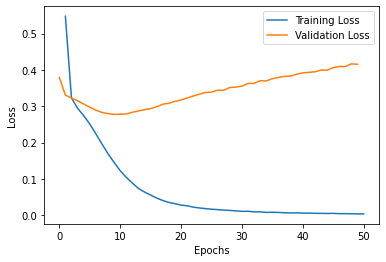

In [ ]:
loss_values = history.history['loss']
vlloss_values = history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(vlloss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

the above plot shows that we have to early stop on around 9 epochs to get best result

In [ ]:
model = get_model(n_inputs, n_outputs)
model.fit(x_train, y_train, verbose=0, epochs=9)

In [ ]:
'''finding best threshold for the NN result'''
thresh =0.0
for _ in range (10):
  nn_y_pred = model.predict(xtest_tfidf) 
  nn_y_pred = (nn_y_pred> thresh).astype(int)
  print(f"threshold: {thresh} --- score: {f1_score(ytest, nn_y_pred, average='micro')}")
  thresh += 0.05

threshold: 0.0 --- score: 0.22057961869563256
threshold: 0.05 --- score: 0.4095744680851064
threshold: 0.1 --- score: 0.5164649225562932
threshold: 0.15000000000000002 --- score: 0.555397051830718
threshold: 0.2 --- score: 0.5709104098657962
threshold: 0.25 --- score: 0.5616218386190286
threshold: 0.3 --- score: 0.5497485239448939
threshold: 0.35 --- score: 0.5227863046044864
threshold: 0.39999999999999997 --- score: 0.4854961832061068
threshold: 0.44999999999999996 --- score: 0.449244060475162


0.2 seems to be giving the best value!

In [ ]:
nn_y_pred_trn = model.predict(xtrain_tfidf)
nn_y_pred_tst = model.predict(xtest_tfidf)

THRESHOLD = 0.2
nn_y_pred_trn = (nn_y_pred_trn >= THRESHOLD).astype(int)
nn_y_pred_tst = (nn_y_pred_tst >= THRESHOLD).astype(int)

In [ ]:
print("*** NUERAL NET CLASSIFIER ***")
print(f"training set f-score: {f1_score(ytrain, nn_y_pred_trn, average='micro')}")
print(f"test set f-score: {f1_score(ytest, nn_y_pred_tst, average='micro')}")


*** NUERAL NET CLASSIFIER ***
training set f-score: 0.8489420742282345
test set f-score: 0.5709104098657962


---------------

# **PART 3 -- Combining TF-IDF and W2V to get better results!**

Exception in thread Thread-5156:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/gensim/models/base_any2vec.py", line 211, in _worker_loop
    tally, raw_tally = self._do_train_job(data_iterable, job_parameters, thread_private_mem)
  File "/usr/local/lib/python3.7/dist-packages/gensim/models/fasttext.py", line 595, in _do_train_job
    tally += train_batch_cbow(self, sentences, alpha, work, neu1)
  File "gensim/models/fasttext_inner.pyx", line 431, in gensim.models.fasttext_inner.train_batch_cbow
TypeError: 'NoneType' object is not subscriptable
Exception in thread Thread-5157:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self

KeyboardInterrupt: ignored